# Data Transfer Through a Network

<img src="DataTransfer.jpg" alt="Drawing" style="width: 500px;"/>


**Recommendation**
* Take a look at the other notebooks before using this notebook to gain familiarity into the workflows and functions, specifically the PreBuilt chains for the introductions to the concepts and the MultiConstellationMultiHop notebook for more of the advanced capabilities.


**Terminology**
* Node = Object in STK
* Edge = Access between two objects in STK
* Strand = The sequence of nodes and edges to complete access in a chain, sometimes called a path

**This notebook shows how to:**
* Transfer data from a set of starting nodes (source/transfer nodes) to a set of ending nodes over time based on bandwidth/capacity of an edge (access between two nodes). 
* The data to be transfered is defined by the user, and various transfer strategies have been implemented, including a specified node priority, no priority and time dynamic priority based on data remaining to be transfered. 
* A chain will be built between each sequential pair in the constellationOrder list. Then networkx will be used build the network with the nodes coming from the constellations and the connections between the nodes coming from the chain accesses. Multiple sublists can be passed into constellationOrderList.
* Typical STK constraints such as range, link duration, Eb/No, etc are taken into account when computing access
* The data  transfer information is stored in dataframes. The data transfered through the network can be shown in STK and can be color coated based on Matplotlib color map. Active objects over the analysis time period or at a time instance can be turned on.

**To reduce the runtime on subsequent runs, this scripts saves various computations to binary files and are reused for subsequent runs.** 
* The strands from the chains will be saved in the SavedNodes folder
* The nodes and associated time delays will be saved in the SavedNodes folder
* The node positions over time are saved in the SavedPositions folder
* The accesses between nodes over time are saved in the SavedEdges folder, default is not to save
* Information about how data was transfered will be saved in the SavedNetwork folder
* These folders will be created as subfolders of the directory used to run the script.
* During the first run the files will automatically be built and saved, subsequent runs will reload these files.
* To make override saved data set the various override flags to be True. Or manually delete the associated .pkl file for any changed strands, nodes, etc. and the script will recompute the data as needed. 
* The script attempts to detect when data needs to be recomputed, but there are edge cases which aren't alwasy covered. If you are seeing weird results with previously loaded data please just delete the old data and for a recompute.

**Potential Future Updates:** 
* Implement faster network processing for special cases. Compute data transfer rates without having to specify the data to transfer. While this doesn't directly improve functionality of the script it can increase runtime performance to handle larger networks. How? By using NetworkX's max_flow function. Which just looks at the max amount of data which can be transfered in a network but it doesn't check if there is data to transfer or care about priorities. This checking process and determining what paths were taken takes additional computation time which about evens out with the current implementation. In the special case where all of the starting and ending nodes are treated each as a "super node" (treating nodes as 1 node instead of seperately and of equal priority) this calculation could be performed much faster then the current implementation. However, the runtime performance should really only come up as an issue for large networks (many hundreds to 1000s of objects) and when there are many starting and ending nodes.
* Add data back to STK. This has been done for data when there is only one dataset per time instance (as shown in the MultiConstellationMultiHop notebook), but STK does not support multiple values at 1 time instance, so the data would need to be broken up into multiple datasets.
* If you need to simulate a more detailed network beyond the physical layer (comm related network metrics) such as packets, channels, protocols, etc. Consider using the Qualnet extension to STK and if you need emulation take a look at Exata. A tutorial can be found here: https://help.agi.com/stk/#training/qualnetTutorial.htm and the help: https://help.agi.com/stk/#comm/qualnet_overview.htm . EXata info: https://www.scalable-networks.com/products/exata-network-emulator-software/ . Contact support@agi.com for more details

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 120)
from comtypes.client import CreateObject
from comtypes.client import GetActiveObject
from comtypes.gen import STKObjects
from comtypes.gen import STKUtil
from comtypes.gen import AgSTKVgtLib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from chainPathLib2 import *
import time
import networkx as nx

folders = ['SavedNodes','SavedPositions','SavedStrands','SavedEdges','SavedNetworkData']
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
import warnings
warnings.filterwarnings('ignore') # Ignore some numpy indexing warnings

## Constellation Connection Order, Computation Time, Save Data Options

Often the hardest part of network analysis is defining the constellation order. Here are some tips:

* Every pair of constellations in the constellationOrderLists will create a one way flow of information (a directed edge) .i.e. [constellation1,constellation2] means constellation1 -> constellation2 but **NOT** constellation2 -> constellation1
    
* To allow for multiple hops between constellations the constelltionOrderLists needs to create a cycle:
    * If you want a constellation to link to itself simply order [constellation1,constellation1]
    * If you want to link to another constellation before linking back to the original [constellation1,constellation2,constellation1]
    * Theoreitcally this cycle can be as big as you want. [c1,c2,....,cN,c1]
    * The reason adding cycles of constellations works is because constellations have multiple objects, so the connections will always be to different objects in the constellation therefore you won't revisit specific nodes in the final path. If the constellation at the beginning of the cycle has only 1 object the cycle will be ignored
    * <img src="CycleIllustration.jpg" alt="Drawing" style="width: 500px;"/>
* The constellationOrderLists **does NOT** require the final path to include every constellation in order, it will find the shortest path among possible connections and cut out unneccesary looping. For example, say you define consetllationOrderLists to be [[start,satConstellation,satConstellation,end]] because you want to allow for intersatellite links in satConstellation, the shortest path may just be from start->satConstellation->end without the need for intersatellitelinks, in which case the intersatellite linking will not be used.
    * This code does not force the use of a cycle aka force intersatellite links to be used in the above example. If you want to do this you have 2 options. Use the prebuilt chains notebook (but it doesn't support multiple hops) or compute multiple shortest paths and filter out any which don't have the desired properties. In the future an improvement may be made to add additional constraints on the shortest path.
    
* To constrain the path for children objects (sensors, transmitters, recievers) you may need to add logical Parent "From" and "To" constraints on the constellations in STK. Think of "From" as the 1st position in a connection (aka transmitting) and "To" as the 2nd position in a connection (aka reiceving). Often you want transmitters to have a "From" Different Parents constraint and recievers to have a "From" Same Parents constraint. The constellation ordering can be set up in a way to force the paths to contain the parent object or to bypass it and only use the children objects. i.e. only use transmitters and recievers and not go to a satellite bus first. For example either of the following orderings could be valid [recievers,satellites,transmitters] (the satellites constellation would need a "From" Same Parent constraint) or [transmitters,receivers].

In [2]:
# The constellationOrderLists builds a directed chain for each adjacent pair in the list
# i.e.: constellationOrderLists = [[A,B],[X,Y,Z,X]] would build chainAB,chainXY,chainYZ,chainZX
# constellationOrderLists represents possible connections, not necessary connections
constellationOrderLists = [['Targets','ObservingSatsFORs','ObservingSats','ObservingSatsTransmitters','ObservingSatsReceivers','ObservingSats','RelaySatsFORs','RelaySats','RelaySatsFORs','EndLocations'],['RelaySats','RelaySats']] # a list of lists

startingConstellation = 'Targets' # complete path starting constellation
endingConstellation = 'EndLocations' # complete path ending constellation

start = 0 # EpSec
stop = 60*60 # EpSec
step = 10 # sec # Time resolution of computations
nodeDelays = {'ObservingSatsFORs':0.01,'ObservingSatsTransmitters':0.005,'ObservingSatsReceivers':0.005,'RelaySatsFORs':0.01,'RelaySats':0.002} # Add in time delays. Provide the constellation name in STK and the node delays
                           
stkVersion = 12
overrideStrands = False # Override previously computed chains
overrideNodeDelaysByNode = False # Override previously built node delay dictionaries
overrideNodesTimesPos = False # Override previously built node positions

In [3]:
# Connect to STK
stkApp = GetActiveObject('STK{}.Application'.format(stkVersion))
stkRoot = stkApp.Personality2
stkRoot.Isolate()
stkRoot.UnitPreferences.SetCurrentUnit('DateFormat','EpSec') # Units to EpSec for ease of use
stkRoot.ExecuteCommand('Units_SetConnect / Date "EpochSeconds"');
try:
    stkRoot.ExecuteCommand('VO * ObjectLine DeleteAll'); # Clean up old object lines
except:
    pass

# Build chains and create a dict of time delays for each node
t1 = time.time()
chainNames = createDirectedChains(stkRoot,constellationOrderLists,start=start,stop=stop,color=12895232)   
print(time.time()-t1)
t1 = time.time()
nodeDelaysByNode = getNodeDelaysByNode(stkRoot,nodeDelays,chainNames=chainNames,overrideData=overrideNodeDelaysByNode)
print(time.time()-t1)

startingNodes = getNodesFromConstellation(stkRoot,startingConstellation)
endingNodes = getNodesFromConstellation(stkRoot,endingConstellation)

0.6696863174438477
0.003022432327270508


## Compute Strands, Strands at Each Time, Node Positions, Edges, Distances, Time Delays

Only need to run this section once unless you change section the above, i.e. the objects in the constellations,the constellation ordering, the start, stop and step times, nodeDelays


In [4]:
# Compute strands, (this is actually a list of all intervals for each edge)
t1 = time.time()
# strands,dfStrands = getAllStrands(stkRoot,chainNames,start,stop,overrideData=overrideStrands)
strands = getAllStrands(stkRoot,chainNames,start,stop,overrideData=overrideStrands)[0] # if memory or performance is an issue don't output dfStrands
print(time.time()-t1)
# dfStrands

Loaded TargetsToObservingSatsFORs.pkl
Loaded ObservingSatsFORsToObservingSats.pkl
Loaded ObservingSatsToObservingSatsTransmitters.pkl
Loaded ObservingSatsTransmittersToObservingSatsReceivers.pkl
Loaded ObservingSatsReceiversToObservingSats.pkl
Loaded ObservingSatsToRelaySatsFORs.pkl
Loaded RelaySatsFORsToRelaySats.pkl
Loaded RelaySatsToRelaySatsFORs.pkl
Loaded RelaySatsFORsToEndLocations.pkl
Loaded RelaySatsToRelaySats.pkl
0.07726526260375977


In [5]:
# Compute node positions, distances and time delays

t1 = time.time()
strandsAtTimes = getStrandsAtTimes(strands,start,stop,step) # Discretize strand intervals into times
t2 = time.time()
print(t2-t1)

t1 = time.time()
nodesTimesPos = computeNodesPosOverTime(stkRoot,strands,start,stop,step,overrideData=overrideNodesTimesPos) # Pull node position over time
t2 = time.time()
print(t2-t1)

# Check if data needed for strandsAtTimes is missing, force a recomputed if needed
t1 = time.time()
strands,nodesTimesPos,strandsAtTimes = recomputeMissingData(strands,nodesTimesPos,strandsAtTimes,recomputeIfDataIsMissing=True)
t2 = time.time()
print(t2-t1)

t1 = time.time()
timeNodePos = computeTimeNodePos(strandsAtTimes,nodesTimesPos) # Nodes and positions at each time
t2 = time.time()
print(t2-t1)

t1 = time.time()
timesEdgesDistancesDelays = computeTimeEdgesDistancesDelays(strandsAtTimes,nodesTimesPos,nodeDelaysByNode,overrideData=True)  # Edges, distances and delays at each time
t2 = time.time()
print(t2-t1)

0.8524892330169678
0.5395967960357666
0.2847902774810791
0.19653534889221191
2.812678575515747


# Data Transfer

How to Use:
* To save the network transfer results to different files change the filename.
* All data and data rates are specified in terms of [units] and [units/sec], the unit could be B,KB,MB,GB, etc. just be consistent in your unit selection
* The data rates will be multipled by the timestep to compute the rate over that interval
* Modify the bandwidthBetweenConstelations values to set the bandwidth between, set a default bandwidth for any edges with unassigned values (large values means unspecified edges have "unlimited" bandwidth, small values means unspecified edges have minimal bandwidth, or this value could be used to save time in applying a ton of default values). Leave the maxDataTransfer to be inf unless you want to limit the total amount of data able to be transfered through the network, it will naturally get fill as the bandwidths fill up
* Specify the bulk data collection at the starting by nodes and the data rates. The bulk data collections happen once at the time instance specified. The data rate continues until it is overridden by a new value. 
* Choose a priority in which you want data to be transfered
* Each unique priority level will be treated as a layer, where the network is constructed in a series of layers with the highest priority starting and ending nodes being in the 1st layer. In each layer all available bandwidth will be used before adding the next layer to the network.

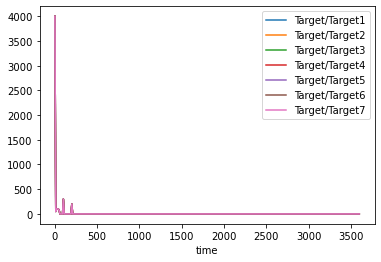

In [6]:
# Options
overrideDataTransferData = True
metric = 'distance' # 'distance' or 'timeDelay' or 'bandwidth'
filename = 'run1' # DataTransfer.pkl,DataSources.pkl,DataDestinations.pkl will be appended to filename, leave empty if desired

# Start of adding bandwidth 
bandwidthBetweenConstellations = {('Targets','ObservingSatsFORs'):5,('RelaySatsFORs','EndLocations'):10} # [data/sec]
defaultBandwidth = 1e15 # This will be the value applied to all nodes not assigned in bandwidthBetweenConstellations, Don't put inf you will get a divide by zero error
maxDataTransfer = np.inf # maxDataTransfer per sec, specify a large number to transfer as much data as possible

# Define starting data, data rate for the start nodes and the end nodes
# Format, a dictionary with time as the key and another dictionary as the value, where the key is the constellation and the value is the data or data rate
# Values can be modifed for specific nodes if desired
bulkDataStartingNodes = {200:{startingConstellation:200},0:{startingConstellation:4000},100:{startingConstellation:300}} # [data], could be in bits,bytes,KB,MB,GB, etc
dataRateStartingNodes = {5:{startingConstellation:10},47:{startingConstellation:0}} # [data/sec]

# Initialize with no data transfered
bulkDataEndingNodes = {0:{endingConstellation:0}}
dataRateEndingNodes = {0:{endingConstellation:0}}

# Take the intial values and turn it into a dictionary over time
timesDataToTransfer = buildTimesNodeAdditionalData(stkRoot,bulkDataStartingNodes,dataRateStartingNodes,start,stop,step)
timesDataTransfered = buildTimesNodeAdditionalData(stkRoot,bulkDataEndingNodes,dataRateEndingNodes,start,stop,step)

# Plot data collection rate
convertTimesDataToDataFrame(timesDataToTransfer,stop).plot(x='time',y=startingNodes);

In [7]:

# Select how data transfer priority should be treated
# priorityCase = 1 # No priority of sources or destinations
# priorityCase = 2 # Priority is highest for the sources with the most data, destinations are treated equally, recomputed at each timestep,
# priorityCase = 3 # Priority is highest for the destinaton with the least data, sources are treated equally, recomputed at each timestep
# priorityCase = 4 # Priority is highest for the sources with the most data and priority is highest for the destinaton with the least data, recomputed at each timestep at each timestep
# priorityCase = 5 # A specified priority will be used, using nodeTransferPriority and nodeDestinationPriority
priorityCase = 2

# Below is only used if priorityCase = 5
# Add in node priorites, the lowest value is the highest priority
defaultPriority = 100
nodeTransferPriority = {node:defaultPriority for node in startingNodes}
nodeTransferPriority['Target/Target1'] = 3
nodeTransferPriority['Target/Target2'] = 3
nodeTransferPriority['Target/Target4'] = 3
nodeTransferPriority['Target/Target5'] = 3
nodeTransferPriority['Target/Target6'] = 1
nodeTransferPriority['Target/Target7'] = 101


nodeDestinationPriority = {node:defaultPriority for node in endingNodes}
nodeDestinationPriority['Place/Los_Angeles_CA'] = 103

nodeTransferPriority,nodeDestinationPriority


({'Target/Target1': 3,
  'Target/Target2': 3,
  'Target/Target3': 100,
  'Target/Target4': 3,
  'Target/Target5': 3,
  'Target/Target6': 1,
  'Target/Target7': 101},
 {'Place/Los_Angeles_CA': 103, 'Place/Washington_DC': 100})

In [8]:
# Force the recomputation of the following dictionaries because they get modified by the computeDataTransferThroughNetowrk function
timesDataToTransfer = buildTimesNodeAdditionalData(stkRoot,bulkDataStartingNodes,dataRateStartingNodes,start,stop,step)
timesDataTransfered = buildTimesNodeAdditionalData(stkRoot,bulkDataEndingNodes,dataRateEndingNodes,start,stop,step)
# Add bandwidths to the timesEdgesDistancesDelays, since bandwidth is data/sec, need to multiple the data rates by the time step to get the total data available to transfer per timestep
bandwidthBetweenConstellationsPerTimeStep = {k:v*step for k,v in bandwidthBetweenConstellations.items()}
timesEdgesDistancesDelaysBandwidths = addEdgeMetricToTimesEdges(stkRoot,timesEdgesDistancesDelays,bandwidthBetweenConstellationsPerTimeStep,defaultValue=defaultBandwidth*step)

# Compute the data transfer through the network
df,dfTimesDataToTransfer,dfTimesDataTransfered,timesEdgesDistancesDelaysBandwidthsUpdated,simulationStopTime = computeDataTransferThroughNetwork(start,stop,step,timeNodePos,timesEdgesDistancesDelaysBandwidths,timesDataToTransfer,timesDataTransfered,startingNodes,endingNodes,priorityCase=priorityCase,nodeTransferPriority=nodeTransferPriority,nodeDestinationPriority=nodeDestinationPriority,metric=metric,maxDataTransfer=maxDataTransfer*step,breakOnceAllDataIsTransfered = True,overrideData=overrideDataTransferData,printTime=True,filename=filename)
print('Total Data Transfered =',sum(df['data transfered']))
df

t= 0 computation time= 0.1616649627685547
t= 10 computation time= 0.09164071083068848
t= 20 computation time= 0.08883285522460938
t= 30 computation time= 0.1013634204864502
t= 40 computation time= 0.09072566032409668
t= 50 computation time= 0.09353065490722656
t= 60 computation time= 0.08885407447814941
t= 70 computation time= 0.07825422286987305
t= 80 computation time= 0.08078384399414062
t= 90 computation time= 0.07878971099853516
t= 100 computation time= 0.07160186767578125
t= 110 computation time= 0.07655978202819824
t= 120 computation time= 0.10244560241699219
t= 130 computation time= 0.06289958953857422
t= 140 computation time= 0.062485694885253906
t= 150 computation time= 0.09573674201965332
t= 160 computation time= 0.07085990905761719
t= 170 computation time= 0.05124616622924805
t= 180 computation time= 0.07954812049865723
t= 190 computation time= 0.0675661563873291
t= 200 computation time= 0.22734379768371582
t= 210 computation time= 0.07950258255004883
t= 220 computation time

,time,strand,distance,data transfered,num hops,num parent hops
0,0,"[Target/Target3, Satellite/ObservingSat62/Sensor/ObservingFOR, Satellite/ObservingSat62, Satellite/RelaySat22/Sensor...",15840.764411,50.0,3.0,2.0
1,0,"[Target/Target3, Satellite/ObservingSat43/Sensor/ObservingFOR, Satellite/ObservingSat43, Satellite/RelaySat22/Sensor...",15855.739713,50.0,3.0,2.0
2,0,"[Target/Target6, Satellite/ObservingSat22/Sensor/ObservingFOR, Satellite/ObservingSat22, Satellite/ObservingSat22/Tr...",22345.701024,50.0,6.0,3.0
3,0,"[Target/Target3, Satellite/ObservingSat72/Sensor/ObservingFOR, Satellite/ObservingSat72, Satellite/ObservingSat72/Tr...",22741.237372,50.0,6.0,3.0
4,0,"[Target/Target6, Satellite/ObservingSat73/Sensor/ObservingFOR, Satellite/ObservingSat73, Satellite/ObservingSat73/Tr...",22866.005861,50.0,6.0,3.0
...,...,...,...,...,...,...
689,800,"[Target/Target3, Satellite/ObservingSat52/Sensor/ObservingFOR, Satellite/ObservingSat52, Satellite/RelaySat22/Sensor...",16041.529408,10.0,3.0,2.0
690,800,"[Target/Target3, Satellite/ObservingSat52/Sensor/ObservingFOR, Satellite/ObservingSat52, Satellite/RelaySat31/Sensor...",17607.811754,10.0,3.0,2.0
691,800,"[Target/Target1, Satellite/ObservingSat71/Sensor/ObservingFOR, Satellite/ObservingSat71, Satellite/RelaySat31/Sensor...",20264.886484,20.0,3.0,2.0
692,810,"[Target/Target6, Satellite/ObservingSat82/Sensor/ObservingFOR, Satellite/ObservingSat82, Satellite/RelaySat12/Sensor...",14129.543706,20.0,3.0,2.0


In [9]:
dfTimesDataToTransfer

,time,Target/Target1,Target/Target2,Target/Target3,Target/Target4,Target/Target5,Target/Target6,Target/Target7
0,0.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0
1,10.0,4050.0,4050.0,3850.0,4050.0,3950.0,3900.0,4000.0
2,20.0,4050.0,3950.0,3950.0,3950.0,4050.0,4000.0,4100.0
3,30.0,4050.0,4050.0,4050.0,4050.0,3950.0,4100.0,4000.0
4,40.0,4100.0,4050.0,3950.0,4150.0,4050.0,3950.0,4100.0
...,...,...,...,...,...,...,...,...
78,780.0,170.0,120.0,220.0,120.0,120.0,120.0,270.0
79,790.0,170.0,120.0,20.0,120.0,120.0,120.0,70.0
80,800.0,20.0,70.0,20.0,120.0,20.0,20.0,70.0
81,810.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0


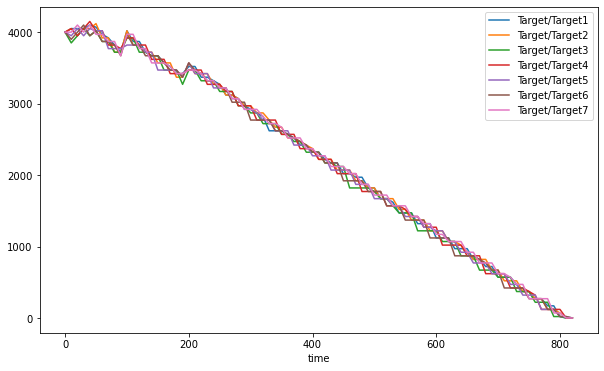

In [10]:
dfTimesDataToTransfer.plot(x='time',y=dfTimesDataToTransfer.columns[1:],figsize=(10,6));

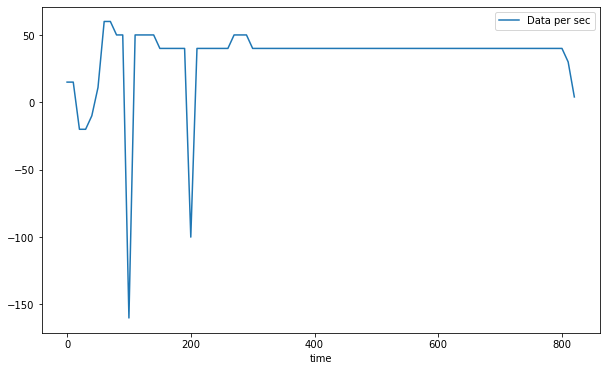

In [11]:
# Network transfer rate = Data transfer rate from starting nodes(+) + New data accumulation at starting nodes (-)
dfData = addDataMetrics(dfTimesDataToTransfer,step)
plt.figure(figsize=(10,6))
plt.plot(dfData['time'],-dfData['Data per sec']);
plt.xlabel('time')
plt.legend(['Data per sec'])
plt.show()

In [12]:
dfTimesDataTransfered

,time,Place/Los_Angeles_CA,Place/Washington_DC
0,0.0,0.0,0.0
1,10.0,200.0,300.0
2,20.0,400.0,600.0
3,30.0,600.0,900.0
4,40.0,900.0,1200.0
...,...,...,...
78,780.0,23400.0,9900.0
79,790.0,23700.0,10000.0
80,800.0,24000.0,10100.0
81,810.0,24300.0,10100.0


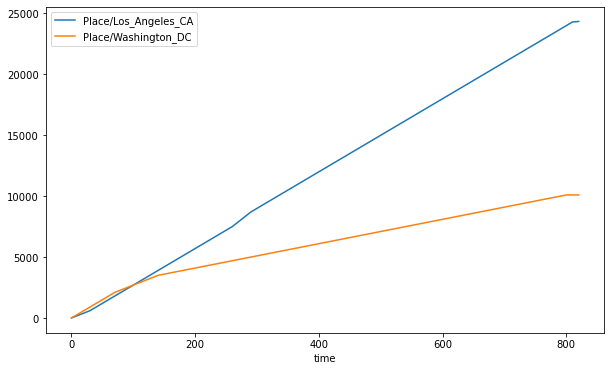

In [13]:
dfTimesDataTransfered.plot(x='time',y=dfTimesDataTransfered.columns[1:],figsize=(10,6));

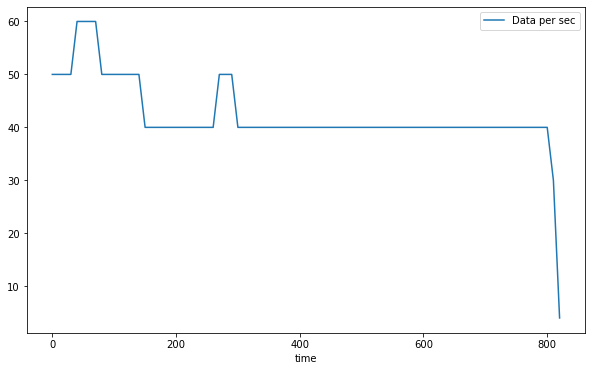

In [14]:
# Network storage rate = data transfered to ending locations/sec 
dfData = addDataMetrics(dfTimesDataTransfered,step)
dfData.plot(x='time',y='Data per sec',figsize=(10,6));

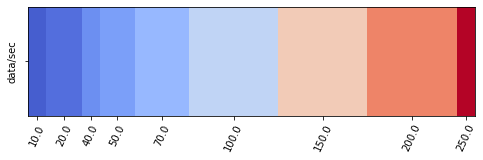

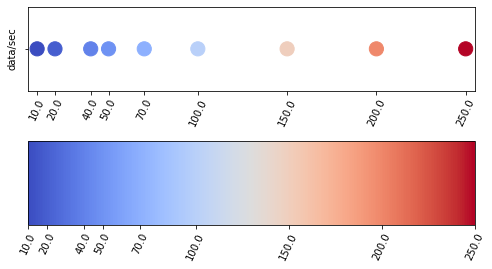

In [15]:
# Load the paths into STK, pick from a color map or specify a specifc color

# Create intervals for each edge and count the number of times the edge is active
# Optionally specify an edge weight which will be multipled by its frequency at each time step
timesEdgeCountAll = createTimesEdgesCountFromDF(df,weightColumn='data transfer')

# # Consider binning the counts to prevent a ton of unique colors, which can noteably speed up the time it takes to add data to STK
# # Look at the pd.cut documentation for specifying specific bin edges
# numBins = 5
# bins = pd.cut(timesEdgeCountAll[:,2],numBins,labels=False)
# timesEdgeCountAll[:,2] = np.round(bins*(max(timesEdgeCountAll[:,2])-min(timesEdgeCountAll[:,2]))/numBins+min(timesEdgeCountAll[:,2]),6)

t1 = time.time()
# Color Maps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# Good options: diverging and sequential color maps such as: cool,coolwarm,Wistia
cmap = cm.get_cmap('coolwarm') # pick a matplotlib color map or don't pass in a colorMap to just use a color
addTimesEdgesCountAsObjectLines(stkRoot,timesEdgeCountAll,step,addTo2D=False,color='%000196196',colorMap=cmap,lineWidth=7)
print(time.time()-t1)

if cmap:
    plotColorbar(timesEdgeCountAll,cmap,plotBoth=True,tickRotationInDeg=65)

## Investigate Edges with the Most Data Transfer and Saturated Edges

In [16]:
# Find the times and edges with data transfered over some value.
# minDataTransferedValue  = 200 # You can set your own cutoff
minDataTransferedValue = np.sort(timesEdgeCountAll[:,2])[-1] # picks the max val
pd.DataFrame(timesEdgeCountAll[timesEdgeCountAll[:,2]>=minDataTransferedValue,:],columns=['time','edge','Data Transfered'])

,time,edge,Data Transfered
0,120,"(Satellite/ObservingSat13/Receiver/ObservingReceiver, Satellite/ObservingSat13)",250


In [17]:
# Find all edges with saturated bandwidth over time
if timesEdgesDistancesDelaysBandwidthsUpdated == timesEdgesDistancesDelaysBandwidths: # May need to regenenerate timesEdgesDistancesDelaysBandwiths becaues it gets modified computeDataTransferThroughNetwork
    timesEdgesDistancesDelaysBandwidths = addEdgeMetricToTimesEdges(stkRoot,timesEdgesDistancesDelays,bandwidthBetweenConstellationsPerTimeStep,defaultValue=defaultBandwidth*step)
filledEdges = np.asarray([(t,edge,val[-1]) for t,data in timesEdgesDistancesDelaysBandwidthsUpdated.items() for edge,val in timesEdgesDistancesDelaysBandwidths[t].items() if edge not in data])
frequencyOfFilledEdges = countEdgesOverTime(filledEdges[:,1],topN=10)
frequencyOfFilledEdges[:,1] = frequencyOfFilledEdges[:,1]/(simulationStopTime/step)*100
dfSaturatedBandwidth = pd.DataFrame(frequencyOfFilledEdges,columns=['edge','Saturated Bandwidth [% of time]'])
dfSaturatedBandwidth 

,edge,Saturated Bandwidth [% of time]
0,"(Satellite/RelaySat31/Sensor/RelaySatFOR, Place/Los_Angeles_CA)",98.7805
1,"(Satellite/RelaySat31/Sensor/RelaySatFOR, Place/Washington_DC)",97.561
2,"(Satellite/RelaySat22/Sensor/RelaySatFOR, Place/Los_Angeles_CA)",95.122
3,"(Satellite/RelaySat12/Sensor/RelaySatFOR, Place/Los_Angeles_CA)",67.0732
4,"(Target/Target1, Satellite/ObservingSat71/Sensor/ObservingFOR)",52.439
5,"(Target/Target7, Satellite/ObservingSat36/Sensor/ObservingFOR)",48.7805
6,"(Target/Target2, Satellite/ObservingSat81/Sensor/ObservingFOR)",40.2439
7,"(Target/Target3, Satellite/ObservingSat62/Sensor/ObservingFOR)",40.2439
8,"(Target/Target7, Satellite/ObservingSat64/Sensor/ObservingFOR)",37.8049
9,"(Target/Target2, Satellite/ObservingSat53/Sensor/ObservingFOR)",36.5854


##  Turn on Active Nodes

In [18]:
# Load df
filenameToLoad = 'SavedNetworkData/{}DataTransfer.pkl'.format(filename)
with open(filenameToLoad,'rb') as f:
    df = pickle.load(f)

In [19]:
# Active objects in the network over time
objPaths = list((set([node for strand in df['strand'].values for node in strand])))

In [20]:
# Turn on the objects in the scenario
turnGraphicsOnOff(stkRoot,objPaths,onOrOff = 'On',parentsOnly = True)

In [21]:
# Turn off the objects in the sceario
turnGraphicsOnOff(stkRoot,objPaths,onOrOff = 'Off',parentsOnly = True)

## Turn On Active Nodes at a Specific Time

In [22]:
# Look at an instance in time (pick a time in df)
t = 0
stkRoot.CurrentTime = t

In [23]:
# Look at strand order and the node delay
objPaths = list((set([node for strand in df.loc[df['time']==t/step,'strand'] for node in strand])))

In [24]:
dataTransferedAtT = pd.DataFrame(timesEdgeCountAll[timesEdgeCountAll[:,0] == t,1:],columns=['edge','data transfered'])
dataTransferedAtT.head()

,edge,data transfered
0,"(Satellite/ObservingSat12, Satellite/ObservingSat12/Transmitter/ObservingTransmitter)",100
1,"(Satellite/ObservingSat12/Sensor/ObservingFOR, Satellite/ObservingSat12)",100
2,"(Satellite/ObservingSat12/Transmitter/ObservingTransmitter, Satellite/ObservingSat13/Receiver/ObservingReceiver)",100
3,"(Satellite/ObservingSat13, Satellite/RelaySat13/Sensor/RelaySatFOR)",200
4,"(Satellite/ObservingSat13/Receiver/ObservingReceiver, Satellite/ObservingSat13)",200


In [25]:
# Turn on the objects in the scenario
turnGraphicsOnOff(stkRoot,objPaths,onOrOff = 'On',parentsOnly = True)

In [26]:
# Turn off the objects in the sceario
turnGraphicsOnOff(stkRoot,objPaths,onOrOff = 'Off',parentsOnly = True)